# Block I. Data loading and basic description

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

df = pd.read_csv('inadvance_synth.csv', sep=';')
#df.info()

df_size = df.shape
print(f"Size of DataFrame: {df_size[0]} lines, {df_size[1]} columnes")

mean_age = df['age'].mean()
print(f"Mean age: {mean_age:.2f} years")

std_age = df['age'].std()
print(f"Age standard deviation: {std_age:.2f}")

missing_values = df.isnull().sum().sort_values(ascending=False)
print("\nColumne sorted by missing values :")
print(missing_values)

categorical_variables = df.select_dtypes(include=['object']).columns
print("\nCategorical variables :")
print(categorical_variables)

label_column = df['label']
positive_cases = (label_column == 1).sum()
negative_cases = (label_column == 0).sum()
print(f"\nPositive case: {positive_cases}")
print(f"Negative case: {negative_cases}")

Size of DataFrame: 38416 lines, 22 columnes
Mean age: 79.40 years
Age standard deviation: 8.36

Columne sorted by missing values :
barthel                28198
num_grupoact3_HOSP     21001
proteina_c_reactiva    18175
urea                   14260
codidiagingreso        11378
glucosa                 9228
potasio                 8646
rdw_sd                  8334
rdw_cv                  8334
hematocrito             8302
leucocitos              8302
sodio                   8142
creatinina              7951
drg                     3640
numurgenciasprevias      552
metastatic_tumor          77
charlson                  77
Unnamed: 0                 0
age                        0
estancias                  0
codservicioreal            0
label                      0
dtype: int64

Categorical variables :
Index(['codidiagingreso', 'codservicioreal'], dtype='object')

Positive case: 13431
Negative case: 24985


# Block II. Data preprocessing

In [2]:
X = df.drop(columns=['label'])  # Toutes les colonnes sauf 'label'
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



1. Training set: 30732 samples, Test set: 7684 samples
2. If a category in the test set is unknown, the parameter handle_unknown='ignore' ensures no column is created for this new category, avoiding mismatch errors.
3. We impute missing values in numeric variables by the mean. If a column in the test set has missing values, that did not exist in the training set, the same imputation process will be applied to ensure consistency
4. It is a terrible idea beacause we leak information for the test set into the training set. This indroduse bias because the model will have seen data it should not have seen before predicting.

# Block III. Modelling & Evaluation

In [3]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


rf_model = RandomForestClassifier(random_state=42)


rf_model.fit(X_train_transformed, y_train)


y_prob = rf_model.predict_proba(X_test_transformed)[:, 1]


auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc}")


y_pred = rf_model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()


sensitivity = tp / (tp + fn)
print(f"Sensitivity (True Positive Rate): {sensitivity}")


specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity}")


AUC-ROC: 0.8961113376926627
Accuracy: 0.825351379489849
Sensitivity (True Positive Rate): 0.653558052434457
Specificity (True Negative Rate): 0.9168328679696849


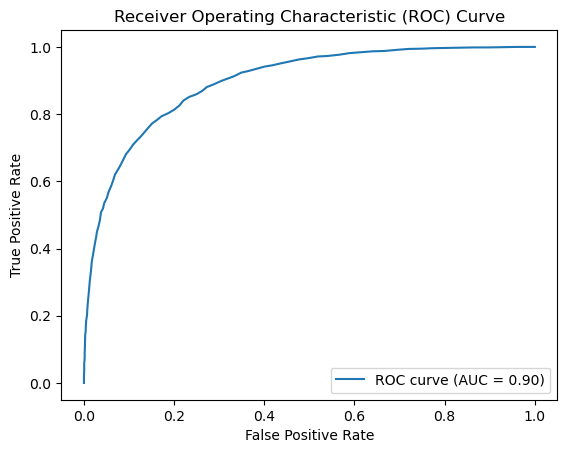

In [4]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_roc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [22]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_space = {
    'classifier__n_estimators': Integer(100, 500),
    'classifier__max_depth': Integer(5, 50),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf': Integer(1, 20),
    'classifier__max_features': Categorical(['sqrt', 'log2'])
}

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=32,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_
print(f"Mejores parámetros: {bayes_search.best_params_}")

Mejores parámetros: OrderedDict([('classifier__max_depth', 50), ('classifier__max_features', 'sqrt'), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 2), ('classifier__n_estimators', 500)])


In [24]:
y_prob = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC en test: {auc_roc}")

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensibilidad (Tasa de Verdaderos Positivos): {sensitivity}")
print(f"Especificidad (Tasa de Verdaderos Negativos): {specificity}")

AUC-ROC en test: 0.8990502996105287
Accuracy en test: 0.8262623633524206
Sensibilidad (Tasa de Verdaderos Positivos): 0.6438202247191012
Especificidad (Tasa de Verdaderos Negativos): 0.9234144395692062


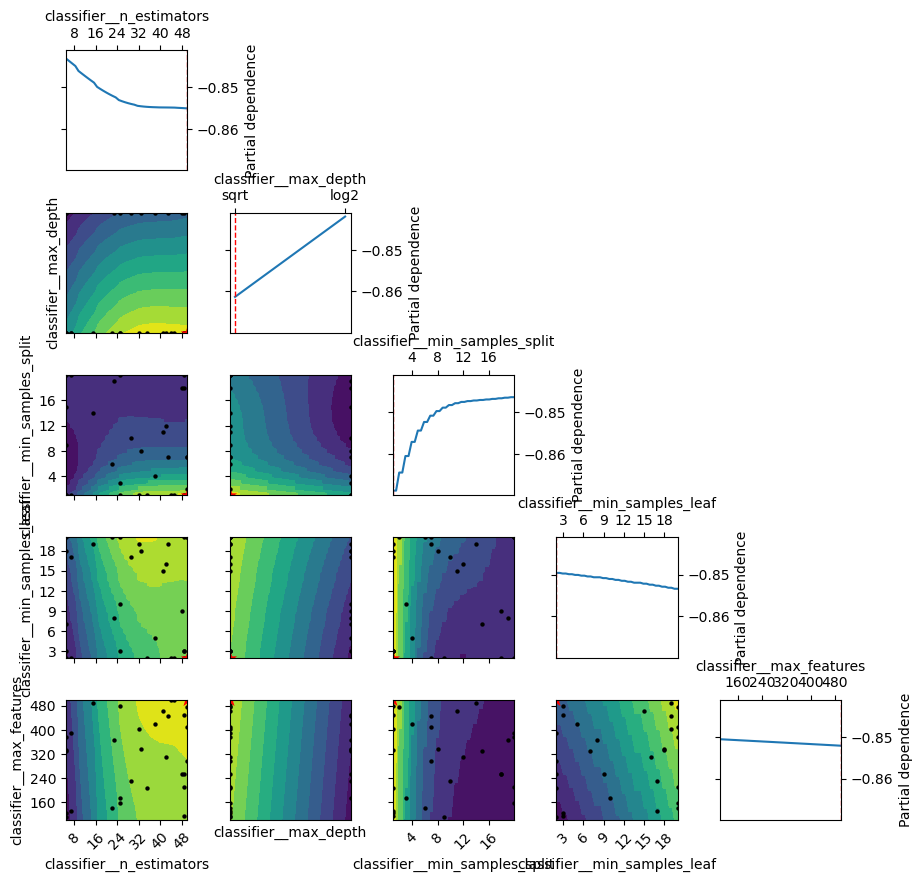

In [43]:
from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_evaluations

_ = plot_objective(bayes_search.optimizer_results_[0],
                   dimensions=["classifier__n_estimators", "classifier__max_depth", 
                               "classifier__min_samples_split", "classifier__min_samples_leaf",
                              "classifier__max_features"],
                   n_minimum_search=1000)
plt.show()

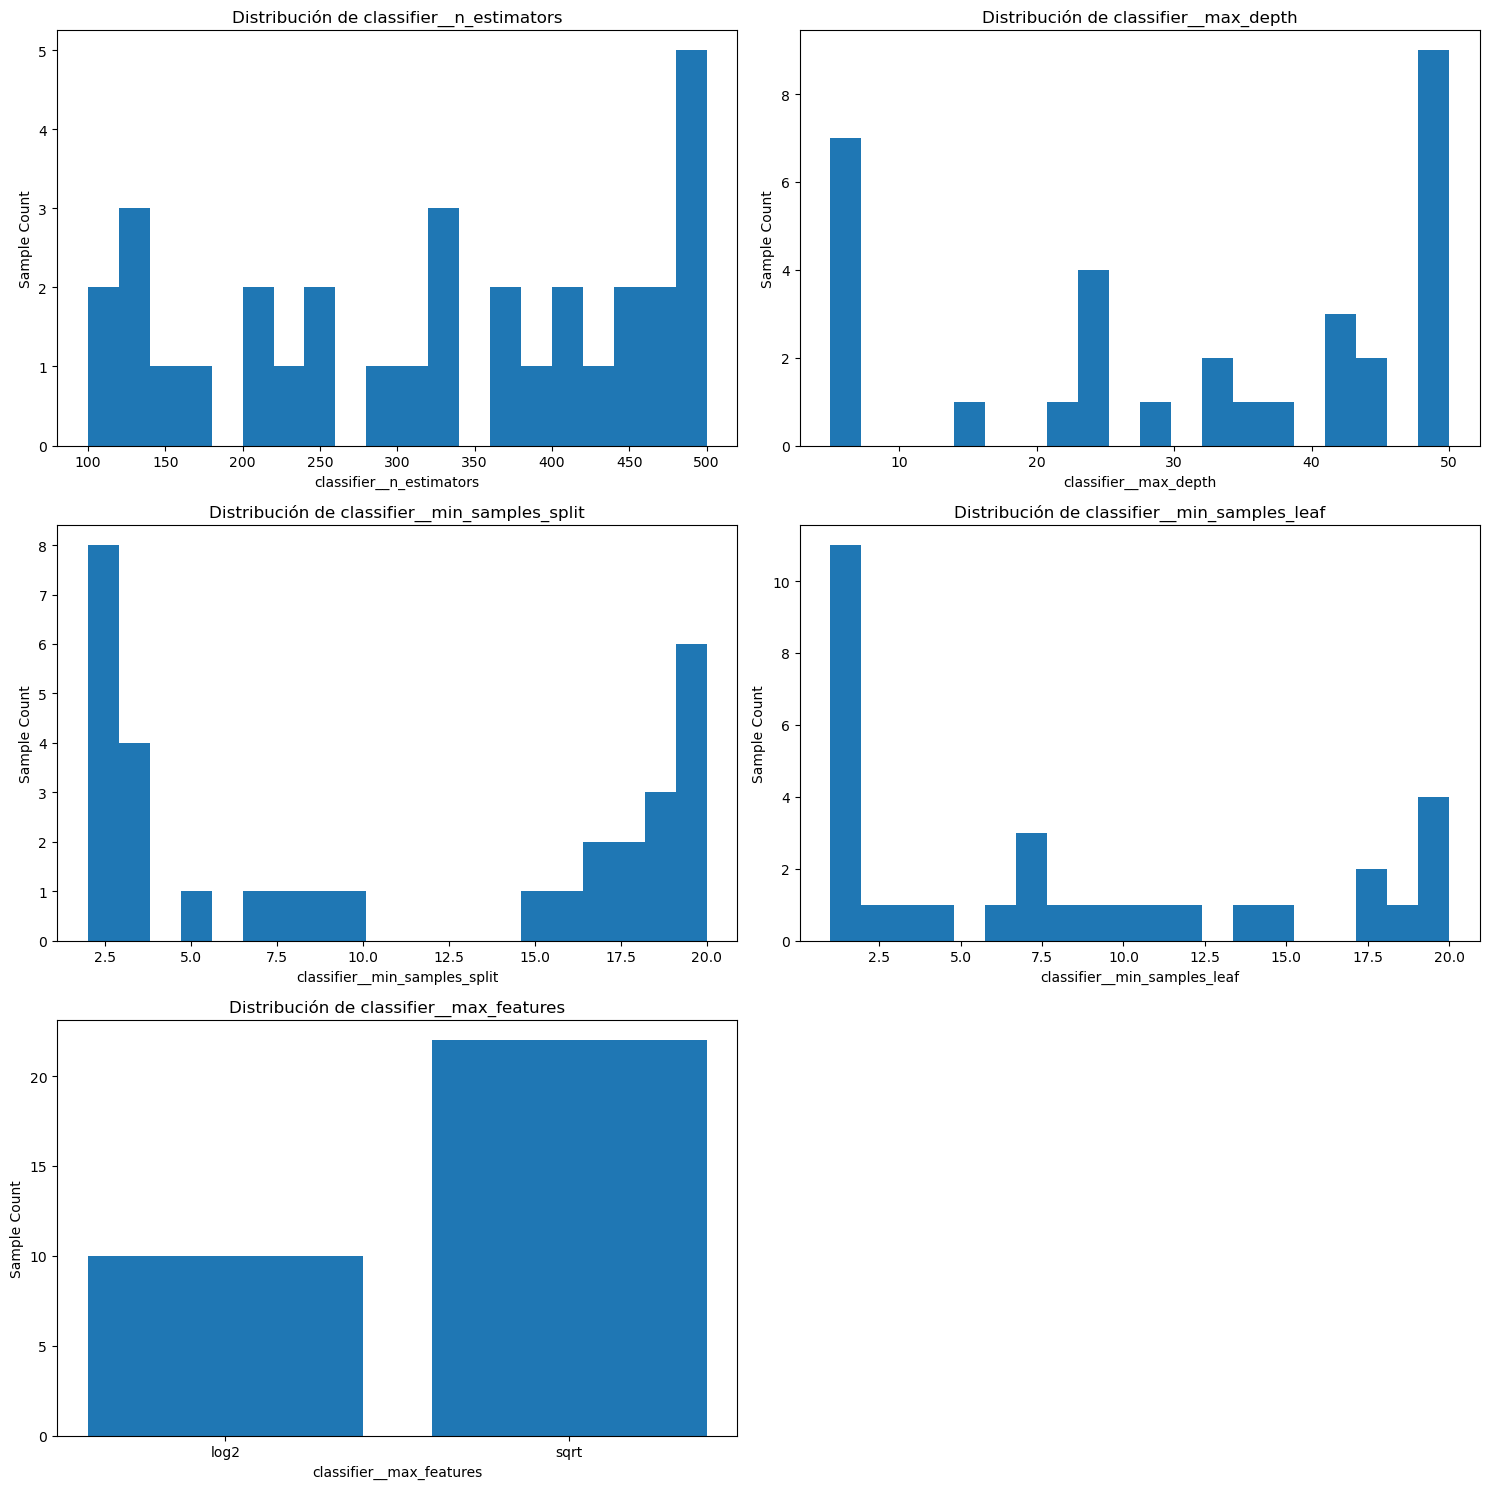

In [41]:
hyperparameters = [
    "classifier__n_estimators",
    "classifier__max_depth", 
    "classifier__min_samples_split",
    "classifier__min_samples_leaf",
    "classifier__max_features"
]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Ajusta el tamaño según sea necesario
axes = axes.flatten()

for i, param in enumerate(hyperparameters):
    plot_histogram(
        bayes_search.optimizer_results_[0],
        dimension_identifier=param,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {param}')

# Eliminar ejes sobrantes si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

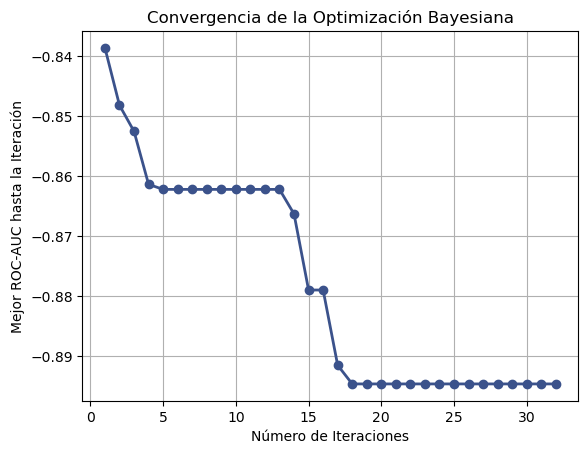

In [44]:
plt.figure()
plot_convergence(bayes_search.optimizer_results_[0])
plt.title('Convergencia de la Optimización Bayesiana')
plt.xlabel('Número de Iteraciones')
plt.ylabel('Mejor ROC-AUC hasta la Iteración')
plt.show()